In [2]:
! gdown https://drive.google.com/u/3/uc?id=1--qv7im7ND4OMJamMZy2WY43Kw4-7SjX

Downloading...
From: https://drive.google.com/u/3/uc?id=1--qv7im7ND4OMJamMZy2WY43Kw4-7SjX
To: /content/znz-classify.zip
495MB [00:02, 184MB/s]


In [3]:
! unzip -qq znz-classify.zip

In [4]:
import os
import cv2
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
from keras.layers import Input, Conv2D, MaxPooling2D, Conv2DTranspose, concatenate, BatchNormalization, Activation, add
from keras.models import Model, model_from_json
from keras.optimizers import Adam
from keras.layers.advanced_activations import ELU, LeakyReLU
from keras.utils.vis_utils import plot_model
from keras import backend as K 
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import glob


In [5]:
import glob
all_img_files = glob.glob('znz-segment-z19/znz-train-z19-all-buffered/images-512/*')
all_mask_files = glob.glob('znz-segment-z19/znz-train-z19-all-buffered/masks-512/*')
print(len(all_img_files))
print(len(all_mask_files))
print(all_img_files[:10])
print(all_mask_files[:10])

#img = cv2.imread('trainx/X_img_144.bmp', cv2.IMREAD_COLOR)
#img.shape

#plt.imshow(img[:,:,::-1])

img_files = glob.glob('znz-segment-z19/znz-train-z19-all-buffered/images-512/*')
msk_files = glob.glob('znz-segment-z19/znz-train-z19-all-buffered/masks-512/*')

img_files.sort()
msk_files.sort()

print(len(img_files))
print(len(msk_files))


2691
2691
['znz-segment-z19/znz-train-z19-all-buffered/images-512/grid_029_corrected_19_319460_270686_img.jpg', 'znz-segment-z19/znz-train-z19-all-buffered/images-512/grid_043_corrected_19_319455_270772_img.jpg', 'znz-segment-z19/znz-train-z19-all-buffered/images-512/grid_001_19_319384_270505_img.jpg', 'znz-segment-z19/znz-train-z19-all-buffered/images-512/grid_043_corrected_19_319461_270794_img.jpg', 'znz-segment-z19/znz-train-z19-all-buffered/images-512/grid_001_19_319366_270499_img.jpg', 'znz-segment-z19/znz-train-z19-all-buffered/images-512/grid_050_19_319442_270804_img.jpg', 'znz-segment-z19/znz-train-z19-all-buffered/images-512/grid_029_corrected_19_319452_270708_img.jpg', 'znz-segment-z19/znz-train-z19-all-buffered/images-512/grid_043_corrected_19_319457_270795_img.jpg', 'znz-segment-z19/znz-train-z19-all-buffered/images-512/grid_029_corrected_19_319443_270717_img.jpg', 'znz-segment-z19/znz-train-z19-all-buffered/images-512/grid_050_19_319469_270832_img.jpg']
['znz-segment-z19/z

In [6]:
X = []
Y = []

for img_fl in tqdm(img_files):
  #print(img_fl)
  #break
  img = cv2.imread('{}'.format(img_fl), cv2.IMREAD_COLOR)
  resized_img = cv2.resize(img,(256, 256), interpolation = cv2.INTER_CUBIC)

  X.append(resized_img)
  mask_name = 'znz-segment-z19/znz-train-z19-all-buffered/masks-512/'+str(img_fl.split('.')[0][:-4]).split('/')[-1]+"_mask_buffered.png"
  #print("mn = ",mask_name)
  #break
  msk = cv2.imread('{}'.format(mask_name), cv2.IMREAD_GRAYSCALE)
  resized_msk = cv2.resize(msk,(256, 256), interpolation = cv2.INTER_CUBIC)

  Y.append(resized_msk)

print(len(X))
print(len(Y))

100%|██████████| 2691/2691 [00:18<00:00, 147.20it/s]

2691
2691


In [7]:

X = np.array(X)
Y = np.array(Y)

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=3)

Y_train = Y_train.reshape((Y_train.shape[0],Y_train.shape[1],Y_train.shape[2],1))
Y_test = Y_test.reshape((Y_test.shape[0],Y_test.shape[1],Y_test.shape[2],1))

X_train = X_train / 255
X_test = X_test / 255
Y_train = Y_train / 255
Y_test = Y_test / 255

Y_train = np.round(Y_train,0)	
Y_test = np.round(Y_test,0)	

print(X_train.shape)
print(Y_train.shape)
print(X_test.shape)
print(Y_test.shape)


(2152, 256, 256, 3)
(2152, 256, 256, 1)
(539, 256, 256, 3)
(539, 256, 256, 1)


In [8]:
def conv2d_bn(x, filters, num_row, num_col, padding='same', strides=(1, 1), activation='relu', name=None):
    '''
    2D Convolutional layers

    Arguments:
        x {keras layer} -- input layer
        filters {int} -- number of filters
        num_row {int} -- number of rows in filters
        num_col {int} -- number of columns in filters

    Keyword Arguments:
        padding {str} -- mode of padding (default: {'same'})
        strides {tuple} -- stride of convolution operation (default: {(1, 1)})
        activation {str} -- activation function (default: {'relu'})
        name {str} -- name of the layer (default: {None})

    Returns:
        [keras layer] -- [output layer]
    '''

    x = Conv2D(filters, (num_row, num_col), strides=strides, padding=padding, use_bias=False)(x)
    x = BatchNormalization(axis=3, scale=False)(x)

    if(activation == None):
        return x

    x = Activation(activation, name=name)(x)

    return x


def trans_conv2d_bn(x, filters, num_row, num_col, padding='same', strides=(2, 2), name=None):
    '''
    2D Transposed Convolutional layers

    Arguments:
        x {keras layer} -- input layer
        filters {int} -- number of filters
        num_row {int} -- number of rows in filters
        num_col {int} -- number of columns in filters

    Keyword Arguments:
        padding {str} -- mode of padding (default: {'same'})
        strides {tuple} -- stride of convolution operation (default: {(2, 2)})
        name {str} -- name of the layer (default: {None})

    Returns:
        [keras layer] -- [output layer]
    '''

    x = Conv2DTranspose(filters, (num_row, num_col), strides=strides, padding=padding)(x)
    x = BatchNormalization(axis=3, scale=False)(x)

    return x


def MultiResBlock(U, inp, alpha = 1.67):
    '''
    MultiRes Block

    Arguments:
        U {int} -- Number of filters in a corrsponding UNet stage
        inp {keras layer} -- input layer

    Returns:
        [keras layer] -- [output layer]
    '''

    W = alpha * U

    shortcut = inp

    shortcut = conv2d_bn(shortcut, int(W*0.167) + int(W*0.333) +
                         int(W*0.5), 1, 1, activation=None, padding='same')

    conv3x3 = conv2d_bn(inp, int(W*0.167), 3, 3,
                        activation='relu', padding='same')

    conv5x5 = conv2d_bn(conv3x3, int(W*0.333), 3, 3,
                        activation='relu', padding='same')

    conv7x7 = conv2d_bn(conv5x5, int(W*0.5), 3, 3,
                        activation='relu', padding='same')

    out = concatenate([conv3x3, conv5x5, conv7x7], axis=3)
    out = BatchNormalization(axis=3)(out)

    out = add([shortcut, out])
    out = Activation('relu')(out)
    out = BatchNormalization(axis=3)(out)

    return out


def ResPath(filters, length, inp):
    '''
    ResPath

    Arguments:
        filters {int} -- [description]
        length {int} -- length of ResPath
        inp {keras layer} -- input layer

    Returns:
        [keras layer] -- [output layer]
    '''


    shortcut = inp
    shortcut = conv2d_bn(shortcut, filters, 1, 1,
                         activation=None, padding='same')

    out = conv2d_bn(inp, filters, 3, 3, activation='relu', padding='same')

    out = add([shortcut, out])
    out = Activation('relu')(out)
    out = BatchNormalization(axis=3)(out)

    for i in range(length-1):

        shortcut = out
        shortcut = conv2d_bn(shortcut, filters, 1, 1,
                             activation=None, padding='same')

        out = conv2d_bn(out, filters, 3, 3, activation='relu', padding='same')

        out = add([shortcut, out])
        out = Activation('relu')(out)
        out = BatchNormalization(axis=3)(out)

    return out


def MultiResUnet(height, width, n_channels):
    '''
    MultiResUNet

    Arguments:
        height {int} -- height of image
        width {int} -- width of image
        n_channels {int} -- number of channels in image

    Returns:
        [keras model] -- MultiResUNet model
    '''


    inputs = Input((height, width, n_channels))

    mresblock1 = MultiResBlock(32, inputs)
    pool1 = MaxPooling2D(pool_size=(2, 2))(mresblock1)
    mresblock1 = ResPath(32, 4, mresblock1)

    mresblock2 = MultiResBlock(32*2, pool1)
    pool2 = MaxPooling2D(pool_size=(2, 2))(mresblock2)
    mresblock2 = ResPath(32*2, 3, mresblock2)

    mresblock3 = MultiResBlock(32*4, pool2)
    pool3 = MaxPooling2D(pool_size=(2, 2))(mresblock3)
    mresblock3 = ResPath(32*4, 2, mresblock3)

    mresblock4 = MultiResBlock(32*8, pool3)
    pool4 = MaxPooling2D(pool_size=(2, 2))(mresblock4)
    mresblock4 = ResPath(32*8, 1, mresblock4)

    mresblock5 = MultiResBlock(32*16, pool4)

    up6 = concatenate([Conv2DTranspose(
        32*8, (2, 2), strides=(2, 2), padding='same')(mresblock5), mresblock4], axis=3)
    mresblock6 = MultiResBlock(32*8, up6)

    up7 = concatenate([Conv2DTranspose(
        32*4, (2, 2), strides=(2, 2), padding='same')(mresblock6), mresblock3], axis=3)
    mresblock7 = MultiResBlock(32*4, up7)

    up8 = concatenate([Conv2DTranspose(
        32*2, (2, 2), strides=(2, 2), padding='same')(mresblock7), mresblock2], axis=3)
    mresblock8 = MultiResBlock(32*2, up8)

    up9 = concatenate([Conv2DTranspose(32, (2, 2), strides=(
        2, 2), padding='same')(mresblock8), mresblock1], axis=3)
    mresblock9 = MultiResBlock(32, up9)

    conv10 = conv2d_bn(mresblock9, 1, 1, 1, activation='sigmoid')

    model = Model(inputs=[inputs], outputs=[conv10])

    return model

In [9]:
def dice_coef(y_true, y_pred):
    smooth = 0.0
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

def jacard(y_true, y_pred):

    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum ( y_true_f * y_pred_f)
    union = K.sum ( y_true_f + y_pred_f - y_true_f * y_pred_f)

    return intersection/union

def saveModel(model):

    model_json = model.to_json()

    try:
        os.makedirs('models')
    except:
        pass

    fp = open('models/MultiResUNET_Zanzibar.json','w')
    fp.write(model_json)
    model.save_weights('models/MultiResUNET_Zanzibar.h5')

In [10]:
jaccard_index_list = []
dice_coeff_list = []

def evaluateModel(model, X_test, Y_test, batchSize):

    try:
        os.makedirs('results')
    except:
        pass


    yp = model.predict(x=X_test, batch_size=batchSize, verbose=1)

    yp = np.round(yp,0)

    for i in range(10):

        plt.figure(figsize=(20,10))
        plt.subplot(1,3,1)
        plt.imshow(X_test[i])
        plt.title('Input')
        plt.subplot(1,3,2)
        plt.imshow(Y_test[i].reshape(Y_test[i].shape[0],Y_test[i].shape[1]))
        plt.title('Ground Truth')
        plt.subplot(1,3,3)
        plt.imshow(yp[i].reshape(yp[i].shape[0],yp[i].shape[1]))
        plt.title('Prediction')

        intersection = yp[i].ravel() * Y_test[i].ravel()
        union = yp[i].ravel() + Y_test[i].ravel() - intersection

        jacard = (np.sum(intersection)/np.sum(union))
        plt.suptitle('Jacard Index'+ str(np.sum(intersection)) +'/'+ str(np.sum(union)) +'='+str(jacard))

        plt.savefig('results/'+str(i)+'.png',format='png')
        plt.close()


    jacard = 0
    dice = 0


    for i in range(len(Y_test)):
        yp_2 = yp[i].ravel()
        y2 = Y_test[i].ravel()

        intersection = yp_2 * y2
        union = yp_2 + y2 - intersection

        jacard += (np.sum(intersection)/np.sum(union))

        dice += (2. * np.sum(intersection) ) / (np.sum(yp_2) + np.sum(y2))


    jacard /= len(Y_test)
    dice /= len(Y_test)



    print('Jacard Index : '+str(jacard))
    print('Dice Coefficient : '+str(dice))

    jaccard_index_list.append(jacard)
    dice_coeff_list.append(dice)
    fp = open('models/log.txt','a')
    fp.write(str(jacard)+'\n')
    fp.close()

    fp = open('models/best.txt','r')
    best = fp.read()
    fp.close()

    if(jacard>float(best)):
        print('***********************************************')
        print('Jacard Index improved from '+str(best)+' to '+str(jacard))
        print('***********************************************')
        fp = open('models/best.txt','w')
        fp.write(str(jacard))
        fp.close()

        saveModel(model)

In [11]:
from tensorflow.keras.metrics import Recall, Precision
import json 

def trainStep(model, X_train, Y_train, X_test, Y_test, epochs, batchSize):
    epochs = 10
    #for epoch in range(epochs):
    #print('Epoch : {}'.format(epoch+1))
    history = model.fit(x=X_train, y=Y_train, batch_size=batchSize, epochs=epochs, verbose=1)

    # convert the history.history dict to a pandas DataFrame:
    hist_df = pd.DataFrame(history.history)

    

    # save to json:
    hist_json_file = 'history.json'
    # with open(hist_json_file, 'a') as out:
    #     out.write(hist_df.to_json())
    #     out.write(",")
    #     out.close()

    with open(hist_json_file, mode='w') as f:
       hist_df.to_json(f)

    # or save to csv:
    hist_csv_file = 'history.csv'
    # with open(hist_csv_file, 'a') as out:
    #     out.write(str(hist_df.to_csv()))
    #     out.write(",")
    #     out.close()


    with open(hist_csv_file, mode='w') as f:
        hist_df.to_csv(f)

    evaluateModel(model,X_test, Y_test,batchSize)

    return model

model = MultiResUnet(height=256, width=256, n_channels=3)

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=[dice_coef, jacard, Recall(), Precision() ,'accuracy'])

saveModel(model)

fp = open('models/log.txt','w')
fp.close()
fp = open('models/best.txt','w')
fp.write('-1.0')
fp.close()

trainStep(model, X_train, Y_train, X_test, Y_test, epochs=150, batchSize=2)

Epoch 1/10
1076/1076 [==============================] - 143s 133ms/step - loss: 0.4606 - dice_coef: 0.2455 - jacard: 0.1477 - recall: 0.6674 - precision: 0.4857 - accuracy: 0.9020
Epoch 2/10
1076/1076 [==============================] - 145s 134ms/step - loss: 0.2657 - dice_coef: 0.3204 - jacard: 0.2007 - recall: 0.6807 - precision: 0.7919 - accuracy: 0.9530
Epoch 3/10
1076/1076 [==============================] - 144s 134ms/step - loss: 0.1995 - dice_coef: 0.3603 - jacard: 0.2297 - recall: 0.5995 - precision: 0.8627 - accuracy: 0.9532
Epoch 4/10
1076/1076 [==============================] - 144s 134ms/step - loss: 0.1749 - dice_coef: 0.3842 - jacard: 0.2464 - recall: 0.4640 - precision: 0.8848 - accuracy: 0.9438
Epoch 5/10
1076/1076 [==============================] - 144s 134ms/step - loss: 0.1663 - dice_coef: 0.3943 - jacard: 0.2540 - recall: 0.3978 - precision: 0.8969 - accuracy: 0.9389
Epoch 6/10
1076/1076 [==============================] - 144s 134ms/step - loss: 0.1633 - dice_coef: 

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:50: RuntimeWarning: invalid value encountered in double_scalars
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:52: RuntimeWarning: invalid value encountered in double_scalars


Jacard Index : nan
Dice Coefficient : nan


In [12]:
import json

with open('history.json', 'r') as f:
    array = json.load(f)
print (array)

{'loss': {'0': 0.4605630636, '1': 0.265735358, '2': 0.1995114535, '3': 0.1748921722, '4': 0.1662882119, '5': 0.1632785499, '6': 0.1598156393, '7': 0.1582370549, '8': 0.1565286666, '9': 0.1584675908}, 'dice_coef': {'0': 0.2455190569, '1': 0.3203893006, '2': 0.360291332, '3': 0.384200424, '4': 0.3942762911, '5': 0.3983168304, '6': 0.4072574675, '7': 0.4088110328, '8': 0.4156178832, '9': 0.4100791216}, 'jacard': {'0': 0.1477277428, '1': 0.2006661296, '2': 0.2296818793, '3': 0.2463770658, '4': 0.2539969981, '5': 0.2572262883, '6': 0.2634693086, '7': 0.2647812366, '8': 0.2701955438, '9': 0.2660119832}, 'recall': {'0': 0.6674135327, '1': 0.6806883216, '2': 0.5994978547, '3': 0.463973999, '4': 0.3978344202, '5': 0.3732051253, '6': 0.3564257324, '7': 0.3431951404, '8': 0.3582991362, '9': 0.3436109722}, 'precision': {'0': 0.4857269526, '1': 0.7918514013, '2': 0.8626923561, '3': 0.8848381639, '4': 0.8969002962, '5': 0.9077212214, '6': 0.9064848423, '7': 0.9119210839, '8': 0.9106305838, '9': 0.91

In [13]:
array['accuracy']

{'0': 0.9020231366,
 '1': 0.9530266523,
 '2': 0.9532455802,
 '3': 0.9437714219,
 '4': 0.9389163256,
 '5': 0.9373300076,
 '6': 0.9358580709,
 '7': 0.9349519014,
 '8': 0.9361857176,
 '9': 0.9349962473}

In [14]:
accuracy = []
for item in array['accuracy']:
  accuracy.append(array['accuracy'][item])
print(accuracy)

[0.9020231366, 0.9530266523, 0.9532455802, 0.9437714219, 0.9389163256, 0.9373300076, 0.9358580709, 0.9349519014, 0.9361857176, 0.9349962473]


In [44]:
# accuracy = []
# for item in array['accuracy']:
#   accuracy.append(array['accuracy'][item])
# #print(accuracy)

# dice_coef = []
# for item in array['dice_coef']:
#   dice_coef.append(array['dice_coef'][item])
# #print(dice_coef)

# loss = []
# for item in array['loss']:
#   loss.append(array['loss'][item])
# #print(loss)

# precision = []
# for item in array['precision']:
#   precision.append(array['precision'][item])
# #print(precision)

# recall = []
# for item in array['recall']:
#   recall.append(array['recall'][item])
# #print(recall)

# plt.figure(figsize=(12,7))

# plt.plot(accuracy)
# plt.plot(dice_coef)
# plt.plot(loss)
# plt.plot(precision)
# plt.plot(recall)

# plt.legend('accuracy', loc='upper left')
# plt.legend('dice coef', loc='upper left')
# plt.legend('loss', loc='upper left')
# plt.legend('precision', loc='upper left')
# plt.legend('recall', loc='upper left')
# plt.show()


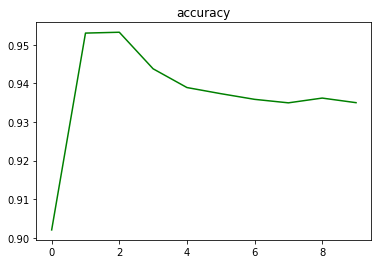

In [43]:
plt.title('accuracy')
plt.plot(accuracy,color='green')

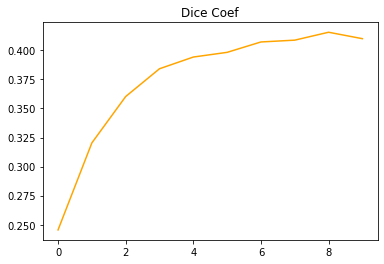

In [42]:
dice_coef = []
for item in array['dice_coef']:
  dice_coef.append(array['dice_coef'][item])
#print(dice_coef)
plt.title('Dice Coef')
plt.plot(dice_coef,color='orange')

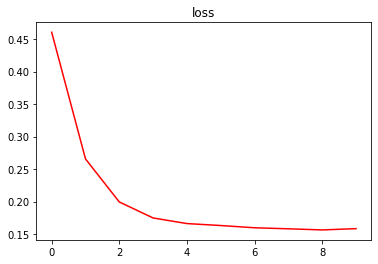

In [40]:
loss = []
for item in array['loss']:
  loss.append(array['loss'][item])
#print(loss)
plt.title('loss')
plt.plot(loss,color='red')

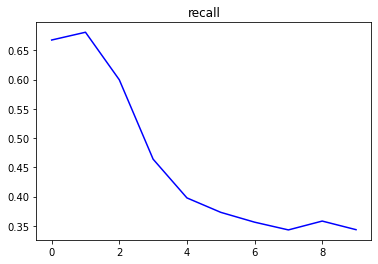

In [39]:
recall = []
for item in array['recall']:
  recall.append(array['recall'][item])
#print(recall)
plt.title('recall')
plt.plot(recall,color='blue')

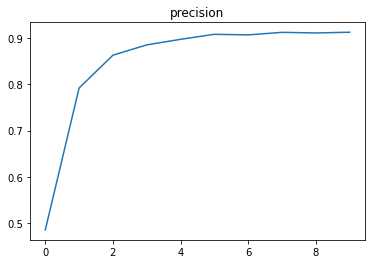

In [38]:
precision = []
for item in array['precision']:
  precision.append(array['precision'][item])
#print(precision)
plt.title('precision')
plt.plot(precision)